<h1>Getting started</h1>

<h1>GPUs</h1>

<p>See our lab infastructure page for list of machines with GPU</p>

<h2>Shared GPUs etiquette</h2>

<h3>Check if others are using the GPU. If they are, then you should try to use a different one</h3>
<ul>
<li>You can corrupt others results if you try and access the GPU at the same time (noticed this with keras)</li>
<li>You can use too much memory and cause the job to crash if you load another model at the same time</li>
</ul>

<p>From the command line, run:</p>
`nvidia-smi`
<p>And you can see if the GPU is in use (memory will be almost full)</p>
<p>From the command line run:</p>
`top`
<p>And you can see what is being run, and by whom!</p>

<h3>Leave large GPUs free if you have small jobs</h3>
<p>Try to use a 2GB GPU if you're just doing some quick prototyping, or if your model is small. This allows others with bigger models to use the larger GPUs</p>

<h3>Eventually we will need some schedule</h3>
<p>If more people are using this, it would be good to somehow let others know when, and how long</p>

<p>A simple complete example showing how to create a CNN for Keras using the CIFAR10 dataset.</p>

<p>We'll go through the following steps that are common to almost all problems:</p>
<ol>
<li>Spliting data into train, valid, and test</li>
<li>preprocessing images</li>
<li>setting up a typical CNN architecture</li>
<li>training the CNN</li>
<li>testing the CNN and reporting metrics</li> 
</ol>

<p>The CNN has 5 layers and shows how to use,</p>
<ul>
<li>convolutional layers</li>
<li>fully-connected layers</li>
<li>max-pooling</li>
<li>batch normalization</li>
<li>dropout</li>
<li>weight regularization</li>
<li>SGD</li>
<li>a function to specify parts of repeated architecture</li>
</ul>

<p>This CNN is very small (only ~116K parameters), and achieves ~77% accuracy after 25 epochs (okay not great accuracy, but hey you grouch, this is just an example).</p>

<p>This takes < 15 mins to train for 25 epochs, using a 2GB NVIDIA GPU.</p>

In [1]:
from __future__ import print_function, division

<h2>Technical note</h2>
<p>I use Python 2.7 instead of the newer 3.X version... This is because, occasionally, there are times when only Python 2.7 is supported.</p>

<p>So this `from __future__` thing forces some parts of the code to behave like Python 3.X</p>

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline 
import numpy as np

import keras
import keras.backend as K
from keras.models import Model
from keras.layers import Conv2D, MaxPooling2D, Input, Flatten, Dropout, Dense
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.normalization import BatchNormalization
from keras.layers.pooling import AveragePooling2D
from keras import optimizers
from keras import initializers
from keras import regularizers

Using TensorFlow backend.


<h3>Minor technical notes</h3>
<p>This code was written for the Keras 2.0 version. This is important! They changed how some of the functions are called in Keras 2.0 vs earlier versions. So if you are getting strange erorrs, check your version of Keras!</p>

In [3]:
from keras.datasets import cifar10

# 10 classes for cifar10.
nb_classes = 10

# Download and load the data.
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

# Convert to float datatype.
X_train = X_train.astype(np.float32)
X_test = X_test.astype(np.float32)

# Normalize so the max value is 1.
X_train /= 255
X_test /= 255

# Change to 1-hot encoding.
Y_train = keras.utils.np_utils.to_categorical(y_train, nb_classes)
Y_test = keras.utils.np_utils.to_categorical(y_test, nb_classes)

In [4]:
# Check our shapes.
print(X_train.shape)
print(X_test.shape)

print(Y_train.shape)
print(Y_test.shape)

(50000, 32, 32, 3)
(10000, 32, 32, 3)
(50000, 10)
(10000, 10)


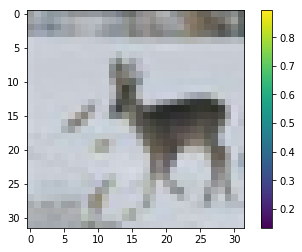

In [5]:
idx = 20
plt.imshow(np.squeeze(X_train[idx,:,:]), interpolation="None"); plt.colorbar()

In [6]:
# Subtract by the mean pixel, so image data is centered around 0.
mean_px = X_train.mean(axis=0).mean(axis=0).mean(axis=0)
X_train -= mean_px

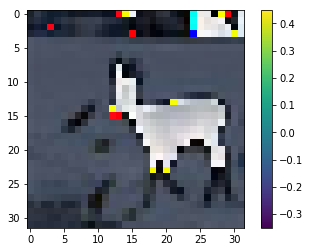

In [7]:
# Looks odd now since it's centered around 0.
idx = 20
plt.imshow(np.squeeze(X_train[idx,:,:]), interpolation="None"); plt.colorbar()

<h1>Clearing the graphs from the GPU memory</h1>

<p>This clears the session's graph. That is all the stuff that's been stored in TensorFlow. 
Run this to clear all the stuff on the GPU.</p>

<p>This is very useful if you're running some cross-validation models, or testing different models.
You'll quickly get out of memory errors. Run this, and re-create your graphs, to avoid having to restart your kernel. </p>

<p>So if you run the below example, and then wanted to re-run it, you should run this `K.clear_session()` to clear the GPU memory, and start again</p>

In [ ]:
# Clear the tensorflow graphs on the GPU memory.
K.clear_session()

<h1>How to initialize the weights is important!</h1>

<p>There are many ways to do this... Most sample from some random initialization around 0.</p>
<p>But from what distribution (usually Gaussian or uniform)?</p>
<p>And with what standard deviation?</p>
<p>A common way, especially when using ReLUs, is to use the intialization proposed by He et al.</p>

<p>
He, K., Zhang, X., Ren, S., & Sun, J. (2016). 
Delving deep into rectifiers: Surpassing human-level performance on imagenet classification. 
In ICCV (pp. 1026–1034). 
http://doi.org/10.1109/ICCV.2015.123
</p>

In [ ]:
# Initialize the weights using He et al.'s approach.
kernel_init = initializers.he_uniform()

In [ ]:
inputs = Input(shape=(32, 32, 3))
padding = 'same' # 'valid' 'same'

In [8]:
reg = regularizers.l2(0.0005)

def conv_bn_relu(x, nb_filters, kernel_size=(3,3), padding='same'):
    x = Conv2D(nb_filters, # How many filters (number of nodes)
               kernel_size=kernel_size, padding=padding, kernel_initializer=kernel_init, kernel_regularizer=reg)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.33)(x)
    return x

x = inputs
x = conv_bn_relu(x, 64, kernel_size=(3,3))
x = MaxPooling2D((2, 2), strides=(2, 2), padding=padding)(x)

x = conv_bn_relu(x, 64, kernel_size=(3,3))
x = MaxPooling2D((2, 2), strides=(2, 2), padding=padding)(x)

x = conv_bn_relu(x, 64, kernel_size=(3,3))
x = MaxPooling2D((2, 2), strides=(2, 2), padding=padding)(x)

x = conv_bn_relu(x, 64, kernel_size=(3,3))
x = MaxPooling2D((2, 2), strides=(2, 2), padding=padding)(x)

# Output layer.
x = Flatten()(x)
x = Dropout(0.5)(x)
preds1 = Dense(nb_classes, kernel_initializer=kernel_init, activation='softmax')(x)

model = Model(inputs=inputs, outputs=[preds1])

# lr = learning rate
sgd = optimizers.SGD(lr=0.01, # Learning rate: probably the most important hyper-parameter to tune!
                              # Try 0.01, if loss does not go down, or if it goes to NaN, 
                              # try 0.001, then 0.0001, then 0.00001, 
                              # This can really make a big difference!
                     decay=1e-6, momentum=0.9, nesterov=True)

model.compile(optimizer=sgd,
              loss='categorical_crossentropy', # The function to optimize. This will determine everything!
              metrics=['accuracy'])

In [9]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 64)        1792      
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 64)        256       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 32, 32, 64)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        36928     
_________________________________________________________________
batch_normalization_2 (Batch (None, 16, 16, 64)        256       
__________

<h1>Train the model</h1>

<h3>Initial goal: lower the training loss</h3>
<p>To start, you should be most interested in if your training loss is going down over epochs. You want to see a clear trend where the training loss decreases. It should decrease quite quickly in the first few epochs, then slower over time.</p>

<p>This should be your main focus at the start. If the training loss is not decreasing, then you probably have a problem with your network somewhere (even if your data is composed of random noise, a large enough network should be able to lower the loss over the dataset just by memorizing the training data).</p>

<p>If the loss is not decreasing, you should look at (in suggested order):</p>
<ul>
<li>lower the learning rate (by a factor of ten, a few times e.g., 0.01, 0.001, 0.0001, 0.00001)</li>
<li>remove regularization (no dropout, no l2-weight regularization)</li>
<li>make sure the output layer and loss function are setup correctly and makes sense for your problem</li>
<li>check how the data is preprocessed and make sure it's not garbled</li>
<li>check your weight initializations</li>
<li>make the layers wider (i.e., more nodes in a hidden layer, not deeper)</li>
</ul>

<p>Note: adding batch normalization often seems to make the training easier. So it's often good to have these layers.</p>

<h3>Secondary goal: </h3>

In [11]:
model.fit(X_train, # The data (what we observe - the images)
          [Y_train], #  The labels (what we want to predict)
          batch_size=32,  # 32 images are going through the net (update based on 32 images). 
                          # If you get out-of-memory errors, try lowering the batch_size.
          epochs=25,  # epoch = full pass over the training data.
          validation_split=0.2, 
          shuffle=True, verbose=2)

Train on 40000 samples, validate on 10000 samples
Epoch 1/25
30s - loss: 1.6757 - acc: 0.4871 - val_loss: 1.4049 - val_acc: 0.5793
Epoch 2/25
29s - loss: 1.3135 - acc: 0.6151 - val_loss: 1.2172 - val_acc: 0.6498
Epoch 3/25
29s - loss: 1.1716 - acc: 0.6594 - val_loss: 1.1349 - val_acc: 0.6701
Epoch 4/25
29s - loss: 1.0871 - acc: 0.6909 - val_loss: 1.0477 - val_acc: 0.6957
Epoch 5/25
29s - loss: 1.0183 - acc: 0.7129 - val_loss: 1.0796 - val_acc: 0.6941
Epoch 6/25
29s - loss: 0.9838 - acc: 0.7230 - val_loss: 0.9793 - val_acc: 0.7248
Epoch 7/25
29s - loss: 0.9556 - acc: 0.7357 - val_loss: 0.9543 - val_acc: 0.7379
Epoch 8/25
29s - loss: 0.9269 - acc: 0.7444 - val_loss: 0.9162 - val_acc: 0.7512
Epoch 9/25
29s - loss: 0.9066 - acc: 0.7537 - val_loss: 0.9307 - val_acc: 0.7475
Epoch 10/25
29s - loss: 0.8867 - acc: 0.7619 - val_loss: 0.9337 - val_acc: 0.7555
Epoch 11/25
28s - loss: 0.8798 - acc: 0.7666 - val_loss: 1.0633 - val_acc: 0.7120
Epoch 12/25
28s - loss: 0.8711 - acc: 0.7715 - val_loss: 